# Call libraries 

In [1]:
import copy
import math
import cmath
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#import matplotlib as mpl

%matplotlib inline
#%matplotlib nbagg

from func import paramin, indexin

# Input from excel file

In [2]:
days_to_compute = 3

test=[*range(0,days_to_compute)]
weather_data=pd.read_excel('weather.xlsx',sheet_name=test,header=0)

In [3]:
weather_data.keys()

dict_keys([0, 1, 2])

In [4]:
weather_data[0].columns

Index(['Time [h]', 'Tatm [ºC]', 'DewPoint [ºF]', 'SolarRad [W/m²]',
       'WindSpeed [mph]'],
      dtype='object')

In [5]:
weather_data[0]

,Time [h],Tatm [ºC],DewPoint [ºF],SolarRad [W/m²],WindSpeed [mph]
0,0,22.000000,44.8,0.000000,0.0
1,1,20.500000,49.1,0.000000,0.0
2,2,20.888889,44.8,0.000000,0.0
3,3,19.611111,43.9,0.000000,0.0
4,4,18.611111,44.2,0.000000,0.0
5,5,18.388889,42.1,27.892000,0.0
6,6,22.611111,44.1,185.946667,0.2
7,7,28.111111,36.7,393.974500,0.2
8,8,31.277778,32.2,593.867167,0.9
9,9,33.277778,28.0,771.678667,2.7


# Polynomial cubic fit / wind speed

In [6]:
def wind_cubic(x,a,b,c,d):
    cubic_fit=a*(x**3)+b*(x**2)+c*x+d
    return cubic_fit

wind_param=np.zeros((days_to_compute,4))
wind_stderr=np.zeros((days_to_compute,4,4))

for i in range(days_to_compute):
    wind_param[i,:],wind_stderr[i,:,:]=curve_fit(wind_cubic,weather_data[i]['Time [h]'], \
                                                weather_data[i]['WindSpeed [mph]'])

In [7]:
wind_approx=np.zeros((days_to_compute,len(weather_data[0]['Time [h]'])))
wind_r2=np.zeros((days_to_compute))

for i in range(days_to_compute):
    wind_approx[i,:] = wind_cubic(weather_data[i]['Time [h]'],*wind_param[i,:])
    residuals = weather_data[i]['WindSpeed [mph]']-wind_approx[i,:]
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((weather_data[i]['WindSpeed [mph]']-np.mean(weather_data[i]['WindSpeed [mph]']))**2)
    wind_r2[i] = 1 - (ss_res / ss_tot)
    
for i in range(days_to_compute):
    for t in range(len(wind_approx[i,:])):
        if wind_approx[i,t]<0: wind_approx[i,t]=0

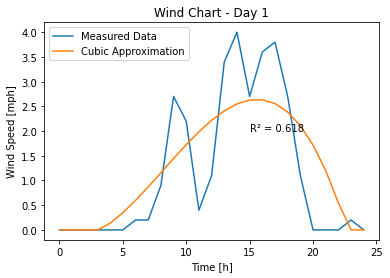

Cubic interpolation parameters [a,b,c,d] = [-0.00178688  0.04413618 -0.0740587  -0.16123077]


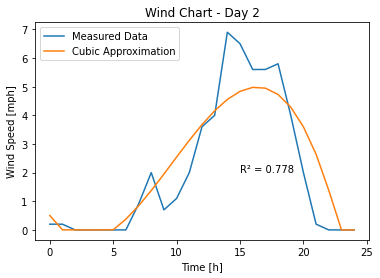

Cubic interpolation parameters [a,b,c,d] = [-0.00437671  0.12637056 -0.62190839  0.50242737]


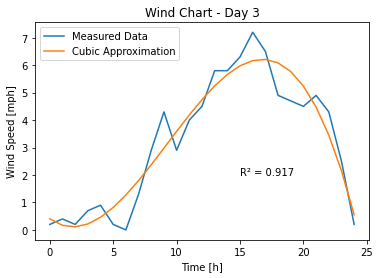

Cubic interpolation parameters [a,b,c,d] = [-0.00365714  0.10203236 -0.33623847  0.40622222]


In [8]:
for i in range(days_to_compute):
    plt.plot(weather_data[i]['Time [h]'],weather_data[i]['WindSpeed [mph]'])
    plt.plot(weather_data[i]['Time [h]'],wind_approx[i,:])
    plt.title('Wind Chart - Day {}'.format(i+1))
    plt.ylabel('Wind Speed [mph]')
    plt.xlabel('Time [h]')
    plt.legend(['Measured Data','Cubic Approximation'])
    plt.text(15,2,'R² = '+str(round(wind_r2[i],3)))
    plt.show()
    print('Cubic interpolation parameters [a,b,c,d] =',wind_param[i,:])

# "Sewing" Input

In [9]:
time = np.arange((len(weather_data[0]['Time [h]'])-1)*days_to_compute+1)

temp_atm = [weather_data[0]['Tatm [ºC]'][0]]
temp_dewpt = [weather_data[0]['DewPoint [ºF]'][0]]
solar_rad = [weather_data[0]['SolarRad [W/m²]'][0]]
wind_speed = [wind_approx[0,0]]

for i in range(days_to_compute):
    temp_atm.extend(weather_data[i]['Tatm [ºC]'][1:].tolist())
    temp_dewpt.extend(weather_data[i]['DewPoint [ºF]'][1:].tolist())
    solar_rad.extend(weather_data[i]['SolarRad [W/m²]'][1:].tolist())
    wind_speed.extend(wind_approx[i,1:].tolist())

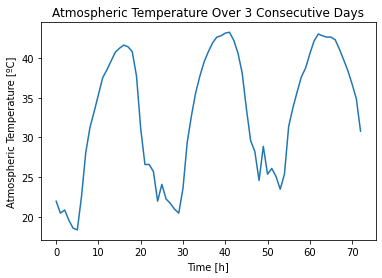

In [10]:
plt.plot(time,temp_atm)
plt.title('Atmospheric Temperature Over '+str(days_to_compute)+' Consecutive Days')
plt.xlabel('Time [h]')
plt.ylabel('Atmospheric Temperature [ºC]')
plt.show()

# NOTE : FORCED CONTINUITY == JUMPS AT 12PM-1AM DUE TO DATA SET
# Tatm(12PM,day1) =/= Tatm(1AM,day2) WHEN SHOULD BE


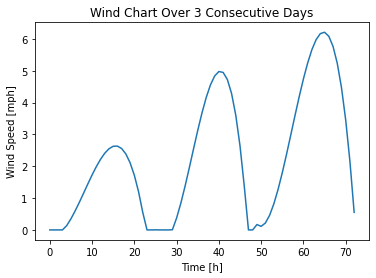

In [11]:
plt.plot(time,wind_speed)
plt.title('Wind Chart Over '+str(days_to_compute)+' Consecutive Days')
plt.xlabel('Time [h]')
plt.ylabel('Wind Speed [mph]')
plt.show()

# NOTE : SAME AS BEFORE, BUT EVEN WITH GOOD DATA, USING CUBIC POLY CAN
#        ALTER THE CONTINUITY ANYWAY


# Linear Interpolation

In [12]:
time = np.arange((len(weather_data[0]['Time [h]'])-1)*days_to_compute+1)
time_step = 120 # [s]
time_sec = time*3600 # [s]
time_interp = np.arange(0,time_sec[-1]+time_step,time_step) # [s]

temp_atm_interp = np.interp(time_interp,time_sec,temp_atm)
temp_dewpt_interp = np.interp(time_interp,time_sec,temp_dewpt)
solar_rad_interp = np.interp(time_interp,time_sec,solar_rad)
wind_speed_interp = np.interp(time_interp,time_sec,wind_speed)

# Unit Conversion 

In [13]:
temp_atm_interp += 273.15 # [ºC] to [K]
temp_dewpt_interp = (temp_dewpt_interp-32)/1.8 # [ºF] to [ºC]
wind_speed_interp *= (16/36) # [mph] to [m/s]

for k in range(len(wind_speed_interp)): 
    if wind_speed_interp[k]<0: wind_speed_interp[k]=0

# Soil Properties 

In [14]:
number_of_layers = 2

density=[2085,2200] # [kg/m³]
spec_heat_capacity=[1298,920] # [J/kg/K]
thermal_conductivity=[0.741,1.20] # [W/m/K]

# node_spacing=0.01 # [m] ~ 0.5 inches

# instability in calculation even with CFL OK > test higher node_spacing
node_spacing=0.0127 # [m] ~ 0.5 inches

pavement_thickness=[round(6.0*0.0254,2)] # [m]
interface_contact_res=[0.001]

surface_albedo=0.15
surface_emissivity=0.97

deep_ground_temp=22.0+273.15 # [K]
ground_layer_depth=3  # [m]

sky_view_factor=0.95
solar_view_factor=0.85

characteristic_length=1 # [m]

In [15]:
pavement_depth=np.zeros(len(pavement_thickness))
pavement_depth[0]=pavement_thickness[0]
for k in range(1,len(pavement_thickness)):
    pavement_depth[k]=pavement_depth[k-1]+pavement_thickness[k]

# Preliminary Calculations and Input

## Outgoing radiation properties

$$T_{sky}=T_{atm}\left(0.004T_{dew}+0.8\right)^{0.25}$$

With:  
-- $T_{sky}$ the sky temperature [K]  
-- $T_{atm}$ the atmospheric dry-bulb temperature [K]  
-- $T_{dew}$ the dew-point temperature [ºC]

In [16]:
stefan_boltzmann=5.67e-8 # [W/m²/K⁴]

In [17]:
temp_sky_interp = temp_atm_interp*(0.004*temp_dewpt_interp+0.8)**(0.25)

## Reference air film properties

In [18]:
ref_temp_flow=[300,350]
ref_viscosity_flow=[1.589e-05,2.092e-05]
ref_conductivity_flow=[2.630e-02,3.000e-02]
ref_diffusivity_flow=[2.250e-05,2.990e-05]
ref_prandtl_flow=[0.707,0.700]

# Formulae used within the recurring scheme

## Radiation coefficient calculation

Outgoing radiation coefficient **depends on SURFACE temperature**:  

$$h_{rad}=\Psi_{sky}\varepsilon\sigma\left(T_S^2+T_{sky}^2\right)\left(T_S+T_{sky}\right)$$  

With:  
-- $h_{rad}$ the abbreviated parameter for outgoing radiative heat transfer coefficient []  
-- $\Psi_{sky}$ the sky view factor []  
-- $\varepsilon$ the infrared emissivity of the surface []  
-- $\sigma=5.67e^{-8}$ the Stefan-Boltzmann constant [W/m²/K⁴]  
-- $T_S$ the pavement surface temperature [K]

## Convection heat transfer calculation

Air film temperature **depends on SURFACE temperature**:

$$T_{film}=\frac{T_{surface}+T_{atm}}{2}$$

$T_{film}$ is then used together with the ***Reference air film properties*** to interpolated or extrapolate the **acutal** air film properties:  

-- kinematic viscosity $\nu_{film}\left(T_{film}\right)$ [m²/s]  
-- conductivity $k_{film}\left(T_{film}\right)$ [W/m/K]  
-- diffusivity $\alpha_{film}\left(T_{film}\right)$ [m²/s]  
-- Prandtl number $\operatorname{Pr}\left(T_{film}\right)$ []

### Reynolds number of air film

**Laminar or turbulent air flow ?**

$$\operatorname{Re}=\frac{U_{film}L}{\nu_{film}}$$

With:  
-- $\operatorname{Re}$ the Reynolds number of air []  
-- $U_{film}$ the wind velocity [m/s]  
-- $L$ the characteristic length of the pavement [m]  
-- $\nu_{film}$ the kinematic viscosity of air [m²/s]  

**If $Re<5e^5$, then the flow is laminar.  
Else it is turbulent.**

### Nusselt number of air film in function of laminar/turbulent flow

For laminar flow:  
$$\operatorname{Nu}_{laminar}=0.664\left[\operatorname{Pr}^{1/3}\operatorname{Re}^{0.5}\right]$$

For turbulent flow:
$$\operatorname{Nu}_{turbulent}=0.037\left[\operatorname{Pr}^{1/3}\operatorname{Re}^{0.8}\right]$$

With:  
-- $\operatorname{Nu}_{xxx}$ the Nusselt number of air []  
-- $\operatorname{Pr}$ the Prandtl number of air []  

### Convective heat transfer coefficient of air hinf

For laminar flow:  
$$h_{laminar}=0.664\left[k_{film}\operatorname{Pr}^{1/3}\nu_{film}^{-0.5}L^{-0.5}U_{film}^{0.5}\right]$$
$$h_{laminar}=\operatorname{Nu}_{laminar}\frac{k_{film}}{L}$$

For turbulent flow:
$$h_{turbulent}=0.037\left[k_{film}\operatorname{Pr}^{1/3}\nu_{film}^{-0.8}L^{-0.2}U_{film}^{0.8}\right]$$
$$h_{turbulent}=\operatorname{Nu}_{turbulent}\frac{k_{film}}{L}$$

With:  
-- $h_{xxx}=h_\infty$ the convective heat transfer coefficient of air []  
-- $k_{film}$ the thermal conductivity of air [W/m/K]  

## Stability verification

Calculate Courant-Friedrichs-Lewy - CFL criterion at all time

$$\Delta t \leq \frac{\rho_S c_S\Delta x^2}{2\left(h_{rad}\Delta x + h_\infty\Delta x + k_S\right)}$$

With:  
-- $\rho_S$ the density of the surface layer [kg/m³]  
-- $c_S$ the specific heat capacity of the surface layer [J/kg/K]  
-- $k_S$ the thermal conductivity of the surface layer [W/m/K]  
-- $\Delta t$ the temporal discretization step [s]  
-- $\Delta x$ the spatial discretization step [m]

# Heat equations development using Finite Differences (FD)

A Forward-Time Central-Space Finite Difference scheme, also known as *explicit scheme*, is used to solve the general 1D diffusion equation:  

$$\frac{\partial u}{\partial t}=\alpha\frac{\partial^2 u}{\partial x^2}$$

With $\alpha$ the diffusivity [m²/s].  

This translates into the following equation:  

$$\frac{u_{m}^{t+1}-u_{m}^{t}}{\Delta t}=\frac{u_{m-1}^{t}-2u_{m}^{t}+u_{m+1}^{t}}{\Delta x^2}$$

Where:  
-- $m$ represents the spacial position of the value of interest $u$  
-- $t$ represents the temporal position of the value of interest $u$  
-- $u_{m}^{t+1}$ is the sole unknown of the equation  

The stencil associated to the FD-FTCS scheme is shown in the next figure:  

![Finite Difference Forward-Time Central-Space Stencil](ftcs.png)

In order to take into account the different phenomena involved in the heat exchange between the pavement slab and its surroundings (environment, old asphalt layers, ground), the general 1D diffusion equation is solved in a different fashion in function of the calculation depth of interest. This can be seen in the following figure **[Gui2007]**:

![Heat transfer phenomena between pavement and its surroundings](gui2007.png)

This way, at the surface (depth = 0 [m]), the equation is modified in order to take into account the input solar radiation, the output infrared radiation of the slab, the thermal convection as well as the thermal conduction. The resulting **equation (1)** can be seen below.  

On the other hand, for interior-nodes (depth > 0 [m]), only thermal conduction has to be taken into account. Thus, a simpler **equation (2)** is developped and used.  

A special case of this equation can be encountered when there is a thermal contact resistance $R_{ij}$ between two different layer of the ground. Such specificity is taken into account thanks to another **equation (3)** that allows taking into account the phenomenon while ensuring heat flux continuity between the $i$ and $j$ layers: 

$$k_i\frac{\text{d}T_i}{\text{d}x}=k_j\frac{\text{d}T_j}{\text{d}x}$$  

and  

$$R_{ij}=\frac{T_{i,\text{interface}}-T_{j,\text{interface}}}{q_{\text{interface}}^"}$$  

With:  
-- $T_{i,\text{interface}}$ and $T_{j,\text{interface}}$ the interface temperatures at the i<sup>th</sup> and j<sup>th</sup> layers, respectively  
-- $q_{\text{interface}}^"$ the heat flux flowing through the interface  

As the *true* initial thermal profile of the slab is unknown, the *Initial Boundary Condition* (BC) $T(t=0,all\text{ }depth)=T_{ground}$ is used.  

Aditionnaly, the following *BC* is taken into account: $T(all\text{ }time,\infty)=T_{ground}$.  

Finally, it is worth noting that, due to the lack of initial thermal profile, an iterative recurring scheme scheme is needed to compute the solution. This recurrence is realized applying $T(t=0,all\text{ }depth)=T(t_{final},all\text{ }depth)$ at each iteration (except the first one, where the initial BC applies).  

A matricial *Frobenius* norm of the difference between thermal profile of iteration $i-1$ and iteration $i$ is used in order to evaluate the convergence of the recurring algorithm and define a suitable stopping criterion.  

$$\mathbb{X}=\left[\text{ThProfile}\right]^{i-1}-\left[\text{ThProfile}\right]^{i}$$

$$\left|\left|\mathbb{X}\right|\right|_F=\sqrt{\sum\limits_i\sum\limits_j\left|x_{ij}\right|^2}$$

## Equation (1): Heat equation for surface-node S
$$T_S^{t+1}=\frac{2\Delta t}{\rho_S c_S \Delta x}\left[h_\infty^{t+1}(T_{atm}^{t+1}-T_S^t)+h_{rad}^{t+1}(T_{sky}^{t+1}-T_S^t)+\Psi_{solar}(1-\bar\alpha)q_S^{"\,t+1}+k_S\frac{T_1^t-T_S^t}{\Delta x}\right]+T_S^t$$

With:  
-- $T_S^{t+1}$ the surface temperature at time $t+1$ [K]  
-- $\Psi_{solar}$ the solar view factor []  
-- $\bar\alpha$ the surface albedo []  
-- $q_S^{"\,t+1}$ the input solar radiation flux [W/m²]  
-- $T_1^t$ the temperature at the first discretized depth at time $t$ [K]  
-- $T_S^{t}$ the surface temperature at time $t$ [K]  

## Equation (2): Interior-node at depth $m$
$$T_m^{t+1}=\frac{k_i \Delta t}{\rho_i c_i \Delta x^2}\left[T_{m-1}^t-2T_m^t+T_{m+1}^t\right]+T_m^t$$

With:  
-- $T_m^{t+1}$ the temperature at depth $m$ and time $t+1$ [K]  
-- $\rho_i$ the density of layer $i$ [kg/m³]  
-- $c_i$ the specific heat capacity of layer $i$ [J/kg/K]  
-- $k_i$ the thermal conductivity of layer $i$ [W/m/K]  
-- $T_{m-1}^t$ the temperature at depth $m-1$ and time $t$ [K]  
-- $T_{m}^t$ the temperature at depth $m$ and time $t$ [K]  
-- $T_{m+1}^t$ the temperature at depth $m+1$ and time $t$ [K]  

## Equation (3): Interface-node at depth $m=n$
$$T_{n}^{t+1}=\frac{1}{2}\left(T_{i,\text{interface}}+T_{j,\text{interface}}\right)$$
$$T_{n}^{t+1}=\frac{1}{2}\left[\frac{2\Delta x k_i+k_i k_j R_{ij}}{k_ik_jR_{ij}+\Delta x k_i+\Delta x k_j}\left(T_{n-1}^t\right)+\frac{2\Delta x k_j+k_i k_j R_{ij}}{k_ik_jR_{ij}+\Delta x k_i+\Delta x k_j}\left(T_{n+1}^t\right)\right]$$

With:  
-- $T_n^{t+1}$ the temperature at depth $n$ and time $t+1$ [K]  
-- $k_i$ and $k_j$ the thermal conductivity of layer $i$ and $j$, respectively [W/m/K]  
-- $R_{ij}$ the thermal contact resistance between layers $i$ and $j$ [0-1]  
-- $T_{n-1}^t$ the temperature at depth $n-1$ and time $t$ [K]    
-- $T_{n+1}^t$  the temperature at depth $n+1$ and time $t$ [K]   

## Coefficient calculations for non-surface depths

For each i<sup>th</sup> layer, some parameters are defined.  

Those are directly related to the heat equations governing the heat energy in- and out-take, as well as it's diffusion within the slab. They are computed in order to simplify the understanding and lecture of the developped code.

Some parameters can be computed **outside** of the iterated recurring scheme, as they are fixed. This is the case for the parameters $\delta_i$, $A_i$ and $B_i$, associated with the interior-node heat equation (2). 

$$T_m^{t+1}=A_iT_m^t+B_i\left(T_{m-1}^t+T_{m+1}^t\right)$$

With:  
-- $\delta_i=\frac{2 \Delta t}{\rho_i c_i \Delta x}$  
-- $A_i=1-\left[\delta_i\frac{k_i}{\Delta x}\right]$  
-- $B_i=\frac{\delta_i k_i}{2\Delta x}$  

Identically, parameters $C_{ij}$ and $D_{ij}$, related to the interface-node equation (3) applied on the i<sup>th</sup> and j<sup>th</sup> layers, are computed beforehand.

$$T_n^{t+1}=C_{ij}T_{n-1}^t+D_{ij}T_{n+1}^t$$

With:  
-- $C_{ij}=\frac{1}{2}\left[\frac{2\Delta x k_i+k_i k_j R_{ij}}{k_ik_jR_{ij}+\Delta x \
k_i+\Delta x k_j}\right]$   
-- $D_{ij}=\frac{1}{2}\left[\frac{2\Delta x k_j+k_i k_j R_{ij}}{k_ik_jR_{ij}+\Delta x \
k_i+\Delta x k_j}\right]$

In [19]:
delta_calc = np.zeros((number_of_layers))
A = np.zeros((number_of_layers))
B = np.zeros((number_of_layers))
C=np.zeros((len(pavement_depth)))
D=np.zeros((len(pavement_depth)))

for layer in range(number_of_layers):
    delta_calc[layer] = (2*time_step)/(density[layer]*spec_heat_capacity[layer]*node_spacing)
    A[layer] = 1-(delta_calc[layer]*thermal_conductivity[layer]/node_spacing)
    B[layer] = 0.5*delta_calc[layer]*thermal_conductivity[layer]/node_spacing

for interface in range(len(pavement_depth)):
    C[interface]=(2*node_spacing*thermal_conductivity[interface] \
                  + thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface]) \
                  / (2* (thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface] \
                       + node_spacing*thermal_conductivity[interface]+node_spacing*thermal_conductivity[interface+1]))
    D[interface]=(2*node_spacing*thermal_conductivity[interface+1] \
                  + thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface]) \
                  / (2* (thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface] \
                       + node_spacing*thermal_conductivity[interface]+node_spacing*thermal_conductivity[interface+1]))

print('[delta_i] =',delta_calc)
print('[Ai] =',A)
print('[Bi] =',B)
print('Cij =',C)
print('Dij =',D)

[delta_i] = [0.00698275 0.00933678]
[Ai] = [0.59258102 0.1177848 ]
[Bi] = [0.20370949 0.4411076 ]
Cij = [0.38587857]
Dij = [0.61412143]


## Coefficient calculations for surface

In the case of the surface-node - equation (1) -, only 2 of the 4 parameters can be calculated outside the iterative loop: $\delta_S$ and $B_S$.  

$$T_S^{t+1}=A_S^{t+1}T_S^t+B_ST_1^t+C_S^{t+1}$$

With:  
-- $\delta_S=\frac{2\Delta t}{\rho_S c_S \Delta x}$  
-- $A_S^{t+1}=1-\delta_S\left[h_\infty^{t+1}+h_{rad}^{t+1}+\frac{k_S}{\Delta x}\right]$  
-- $B_S=\delta_S\frac{k_S}{\Delta x}$  
-- $C_S^{t+1}=\delta_S\left[h_\infty^{t+1}T_{atm}^{t+1}+h_{rad}^{t+1}T_{sky}^{t+1}+\Psi_{solar}(1-\bar\alpha)q_S^{"\,t+1}\right]$  

However, parameters $A_S^{t+1}$ and $C_S^{t+1}$ need to be included into the recurring scheme as they depends on the convective ($h_\infty$) and outgoing radiative ($h_{rad}$) coefficients, which themselves depend on the surface temperature $T_S^t$.

In [20]:
delta_surf = (2*time_step)/(density[0]*spec_heat_capacity[0]*node_spacing)
Bsurf = delta_surf*thermal_conductivity[0]/node_spacing
print('delta_surf =',delta_surf)
print('Bsurf =',Bsurf)

delta_surf = 0.006982754429532095
Bsurf = 0.4074189789199435


# FD-FTCS (*Finite-Difference Forward Time Central Space*) recurring scheme

In [21]:
profile = np.zeros((len(time_interp),int(ground_layer_depth/node_spacing)+1))

hrad = np.zeros((len(time_interp)))
convective_heat_air = np.zeros((len(time_interp)))
delta_t = np.zeros((len(time_interp)))
Asurf = np.zeros((len(time_interp)))
Csurf = np.zeros((len(time_interp)))

normM = np.zeros((50))

stab_flag = False

for ite in range(50):
    
    if ite==0:
        profile[-1,:].fill(deep_ground_temp)
    
    profile_old=copy.copy(profile)
    
    for time in range(0,profile.shape[0]):
        
        ##### hrad calculation #####
        hrad[time] = sky_view_factor*surface_emissivity*stefan_boltzmann*(profile[time-1,0]**2+temp_sky_interp[time]**2)*(profile[time-1,0]+temp_sky_interp[time])
        ############################
        
        ##### air film properties calculation #####
        film_temp = 0.5*(profile[time-1,0]+temp_atm_interp[time])
        film_viscosity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                         *(ref_viscosity_flow[1]-ref_viscosity_flow[0])+ref_viscosity_flow[0]
        film_conductivity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                            *(ref_conductivity_flow[1]-ref_conductivity_flow[0])+ref_conductivity_flow[0]
        film_diffusivity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                            *(ref_diffusivity_flow[1]-ref_diffusivity_flow[0])+ref_diffusivity_flow[0]
        film_prandtl = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                       *(ref_prandtl_flow[1]-ref_prandtl_flow[0])+ref_prandtl_flow[0]
        film_beta = 1 / film_temp

        film_reynolds = wind_speed_interp[time] * characteristic_length / film_viscosity
        film_nusselt_laminar = 0.664 * film_reynolds**(0.5) * film_prandtl**(1/3)
        film_nusselt_turbulent = 0.037 * film_reynolds**(0.8) * film_prandtl**(1/3)

        if film_reynolds<5e5:
            film_nusselt_actual=film_nusselt_laminar
        else:
            film_nusselt_actual=film_nusselt_turbulent
            print('WATCH OUT : Turbulent flow!')
        ###########################################
        
        ##### hinf calculation (from air film prop) #####
        convective_heat_air[time] = film_nusselt_actual * film_conductivity / characteristic_length
        #################################################
        
        ##### CFL criterion validation #####
        delta_t[time]=(node_spacing**2)*density[0]*spec_heat_capacity[0] / (2*(hrad[time]*node_spacing+convective_heat_air[time]*node_spacing+thermal_conductivity[0]))
        stability = delta_t[time] > time_step
        
        if stability==False: 
            print('Unstable FD scheme, breaking!')
            stab_flag = True
            break
        ####################################
        
        ##### A & C surface coefficients #####
        Asurf[time] = 1-(delta_surf*(hrad[time]+convective_heat_air[time]+thermal_conductivity[0]/node_spacing))
        Csurf[time] = delta_surf*(hrad[time]*temp_sky_interp[time]+convective_heat_air[time]*temp_atm_interp[time] + \
                           solar_view_factor*(1-surface_albedo)*solar_rad_interp[time])
        ######################################       
        
        for depth in range(profile.shape[1]):
            depth_m=round(depth*node_spacing,2)
            if depth_m==0:
                profile[time,depth] = Asurf[time]*profile[time-1,depth]+Bsurf*profile[time-1,depth+1]+Csurf[time]
                
            elif depth_m<=pavement_depth[-1]:
                for interface in range(len(pavement_depth)):
                    if depth_m<pavement_depth[interface]:
                        profile[time,depth] = A[interface]*profile[time-1,depth] \
                                            + B[interface]*(profile[time-1,depth-1]+profile[time-1,depth+1])
                        break

                    elif depth_m==pavement_depth[interface]:
                        profile[time,depth] = C[interface]*profile[time-1,depth-1] \
                                            + D[interface]*profile[time-1,depth+1]
                        break

            elif depth_m!=ground_layer_depth:
                profile[time,depth] = A[-1]*profile[time-1,depth] \
                                    + B[-1]*(profile[time-1,depth-1]+profile[time-1,depth+1])

            else:
                profile[time,depth] = deep_ground_temp
        
    if stab_flag == True:
        break
    
    profile_diff=profile_old-profile
    normM[ite] = np.linalg.norm(profile_diff,'fro')
    
    print('\n')
    print('Recurring Iteration '+str(ite+1))
    print('Frobenius Norm =',normM[ite])
    
    if normM[ite]<=50:
        print('\nCONVERGENCE CRITERION Fnorm(X)<50 REACHED!')
        break



Recurring Iteration 1
Frobenius Norm = 212259.30922270258


Recurring Iteration 2
Frobenius Norm = 2247.7258267114553


Recurring Iteration 3
Frobenius Norm = 1239.2718906189054


Recurring Iteration 4
Frobenius Norm = 910.7387751377462


Recurring Iteration 5
Frobenius Norm = 731.7636284804369


Recurring Iteration 6
Frobenius Norm = 611.9342493334534


Recurring Iteration 7
Frobenius Norm = 520.9722594091827


Recurring Iteration 8
Frobenius Norm = 446.95567815216094


Recurring Iteration 9
Frobenius Norm = 384.6861238345648


Recurring Iteration 10
Frobenius Norm = 331.5266453776504


Recurring Iteration 11
Frobenius Norm = 285.8645979034892


Recurring Iteration 12
Frobenius Norm = 246.54352484013904


Recurring Iteration 13
Frobenius Norm = 212.64836178958686


Recurring Iteration 14
Frobenius Norm = 183.41857013579312


Recurring Iteration 15
Frobenius Norm = 158.20806582205623


Recurring Iteration 16
Frobenius Norm = 136.46292866074734


Recurring Iteration 17
Frobenius Norm 

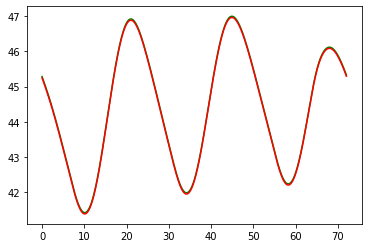

In [23]:
plt.plot(time_interp/3600,profile[:,15]-273.15,'green')
plt.plot(time_interp/3600,profile_old[:,15]-273.15,'red')

In [24]:
print(max(profile[:,15]-273.15))
print(min(profile[:,15]-273.15))
print(np.mean(profile[:,15]-273.15))

46.99252652952754
41.42931353871529
44.36527319812667


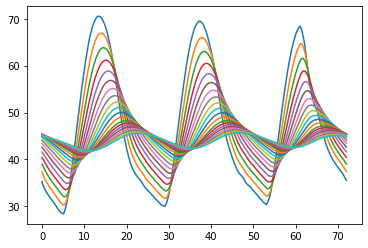

In [25]:
for k in range(20):
    plt.plot(time_interp/3600,profile[:,k]-273.15)

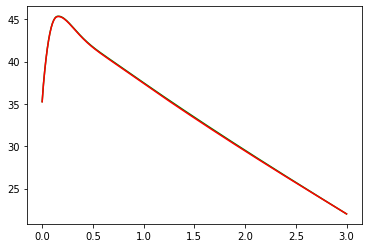

In [26]:
plt.plot(np.linspace(0,ground_layer_depth,profile.shape[1]),profile[0,:]-273.15,'green')
plt.plot(np.linspace(0,ground_layer_depth,profile.shape[1]),profile_old[0,:]-273.15,'red')

In [27]:
a = [1,2]
print('a =',a)
b = a
print('b =',b)
a[0]=3
print('a =',a)
print('b =',b)

a = [1, 2]
b = [1, 2]
a = [3, 2]
b = [3, 2]
